# Многоклассовая классификация с XGBoost + Optuna

**Цель:** Классификация типов трафика при помощи ML-модели.

**Использованные алгоритмы:** XGBoost, Optuna.

**Датасет:** Датасет состоит из 2830743 записей, 79 показателей трафика и 14 классов трафика (стандартный и 13 фродовых).

**Источник данных:** 

https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset

**Загрузка библиотек:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib

from xgboost import XGBClassifier

import optuna
from optuna.visualization import plot_param_importances

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, 
                             classification_report,
                             f1_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample

**Загрузка датасета:**

In [2]:
df = pd.read_csv('CIC-IDS2017.csv')

df.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
239476,53,30657,1,1,42,58,42,42,42.000000,0.000000,...,20,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
1875181,53,225,2,2,68,182,34,34,34.000000,0.000000,...,32,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
708565,53,31942,1,1,58,139,58,58,58.000000,0.000000,...,32,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
2334911,443,126789,10,5,810,463,565,0,81.000000,176.392870,...,32,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
1970609,443,117325900,14,14,913,6527,260,0,65.214286,85.754729,...,20,135246.0,74253.28309,187751,82741,5.850000e+07,6.346983e+05,58900000,58000000,BENIGN
2184653,443,126361,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
2702265,80,80706107,8,6,56,11607,20,0,7.000000,5.656854,...,20,849.0,0.00000,849,849,4.030000e+07,4.540000e+07,72400000,8164110,DDoS
2825343,8080,8720037,3,0,0,0,0,0,0.000000,0.000000,...,28,3000054.0,0.00000,3000054,3000054,5.719983e+06,0.000000e+00,5719983,5719983,BENIGN
2039709,53,230,2,2,64,148,32,32,32.000000,0.000000,...,40,0.0,0.00000,0,0,0.000000e+00,0.000000e+00,0,0,BENIGN
2553468,443,116662852,24,21,1622,8169,1232,0,67.583333,253.172723,...,32,103809.0,231974.85670,840428,36678,9.618095e+06,1.362668e+06,10000000,5291087,BENIGN


# Предобработка данных

**Размер датасета до очистки:**

In [3]:
df.shape

(2830743, 79)

**Замена бесконечных значений на NaN-значения:**

In [4]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

**Удаление NaN-значений и дупликатов:**

In [5]:
df.dropna(inplace = True)
df.drop_duplicates(inplace = True)
df.shape

(2520798, 79)

**Удаление пробелов в начале названий столбцов:**

In [6]:
df.columns = df.columns.str.strip()

In [7]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

**Типы данных переменных:**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2520798 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Destination Port             int64  
 1   Flow Duration                int64  
 2   Total Fwd Packets            int64  
 3   Total Backward Packets       int64  
 4   Total Length of Fwd Packets  int64  
 5   Total Length of Bwd Packets  int64  
 6   Fwd Packet Length Max        int64  
 7   Fwd Packet Length Min        int64  
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        int64  
 11  Bwd Packet Length Min        int64  
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 int64  
 19  Flow 

**Количество записей с каждым лейблом:**

In [9]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [10]:
df['Label'] = df['Label'].str.replace('�', '-', regex=False)

**Кодирование и группировка значений y-переменной:**

In [11]:
def prepare_labels(df, drop_classes=['Rare']):
    original_labels = df['Label']
    mapping = {'BENIGN': 'Normal',
               'Bot': 'Bot',
               'DDoS': 'DoS',
               'DoS slowloris': 'DoS',
               'DoS Slowhttptest': 'DoS',
               'DoS Hulk': 'DoS',
               'DoS GoldenEye': 'DoS',
               'FTP-Patator': 'BruteForce',
               'SSH-Patator': 'BruteForce',
               'Heartbleed': 'Rare',
               'Infiltration': 'Rare',
               'PortScan': 'Recon',
               'Web Attack - Brute Force': 'Web',
               'Web Attack - XSS': 'Web',
               'Web Attack - Sql Injection': 'Web'}

    grouped_labels = original_labels.map(mapping)
    valid_mask = grouped_labels.notna()
    grouped_labels = grouped_labels[valid_mask].reset_index(drop=True)
    df_clean = df.loc[valid_mask].reset_index(drop=True)

    if drop_classes:
        drop_mask = ~grouped_labels.isin(drop_classes)
        grouped_labels = grouped_labels[drop_mask].reset_index(drop=True)
        X = df_clean.drop('Label', axis=1).loc[drop_mask].reset_index(drop=True)
    else:
        X = df_clean.drop('Label', axis=1).reset_index(drop=True)

    final_encoder = LabelEncoder()
    y_clean = final_encoder.fit_transform(grouped_labels)

    return X, y_clean, final_encoder

In [12]:
X, y, final_encoder = prepare_labels(df, drop_classes=['Rare'])
values, counts = np.unique(y, return_counts=True)
class_names = final_encoder.inverse_transform(values)

distribution = dict(zip(class_names, counts))
print(distribution)

{'Bot': 1948, 'BruteForce': 9150, 'DoS': 321759, 'Normal': 2095057, 'Recon': 90694, 'Web': 2143}


**Визуализация классов после кодирования, группировки пременных и удаления малочисленного класса:**

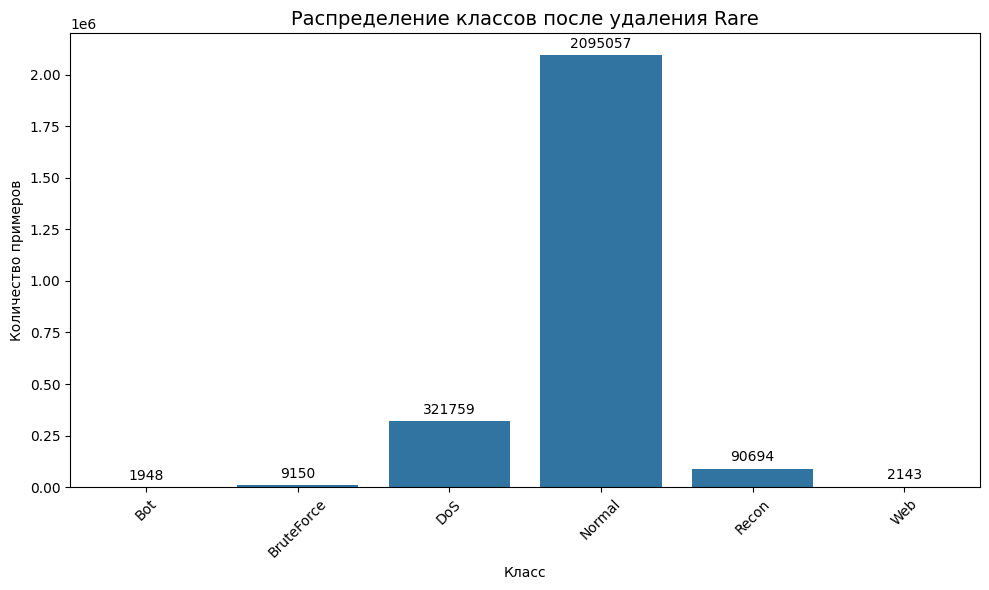

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts)

for i, count in enumerate(counts):
    plt.text(i, count + max(counts)*0.01, str(count), ha='center', va='bottom', fontsize=10)

plt.title('Распределение классов после удаления Rare', fontsize=14)
plt.xlabel('Класс')
plt.ylabel('Количество примеров')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Разделение на выборки:**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2, 
                                                    random_state=42)

**Веса классов:**

In [15]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=classes, 
                                     y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
weights = np.array([class_weight_dict[label] for label in y_train])

**Обучение базовой модели на всех признаках:**

In [ ]:
model_all = XGBClassifier(n_estimators=300,
                          max_depth=6,
                          learning_rate=0.1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          eval_metric='mlogloss',
                          n_jobs=-1,
                          random_state=42)

model_all.fit(X_train, y_train, sample_weight=weights)
y_pred_all = model_all.predict(X_test)
report_all = classification_report(y_test, y_pred_all, output_dict=True)

**SHAP-анализ:**

100%|===================| 2994/3000 [02:35<00:00]        

Топ-20 признаков по SHAP:
                    feature  mean_abs_shap
0          Destination Port       0.577761
66   Init_Win_bytes_forward       0.435211
67  Init_Win_bytes_backward       0.354551
37            Bwd Packets/s       0.206289
69     min_seg_size_forward       0.198479
22              Fwd IAT Std       0.169074
19             Flow IAT Min       0.142918
11    Bwd Packet Length Min       0.136412
36            Fwd Packets/s       0.128266
24              Fwd IAT Min       0.126714
18             Flow IAT Max       0.110424
13    Bwd Packet Length Std       0.110012
14             Flow Bytes/s       0.105959
46           PSH Flag Count       0.101405
21             Fwd IAT Mean       0.101179
40       Packet Length Mean       0.100409
34        Fwd Header Length       0.096736
12   Bwd Packet Length Mean       0.086862
1             Flow Duration       0.083743
16            Flow IAT Mean       0.074599


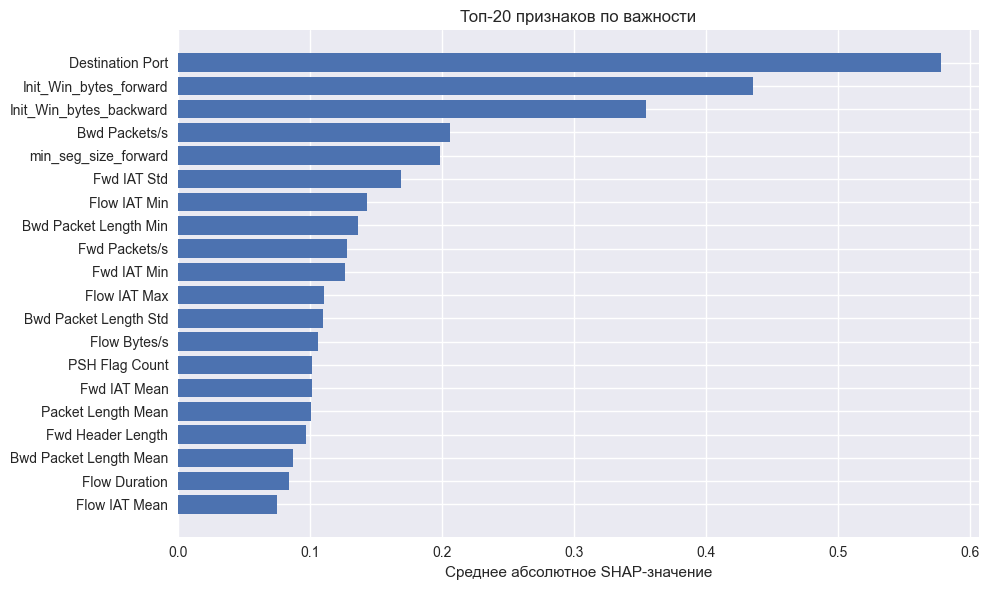

In [66]:
X_sample, y_sample = resample(X_test, y_test, n_samples=500, stratify=y_test, random_state=42)

explainer = shap.Explainer(model_all, X_train)
shap_values = explainer(X_sample)
mean_abs_shap = np.abs(shap_values.values).mean(axis=(0, 2))

top_features_idx = np.argsort(mean_abs_shap)[::-1]

feature_importance = pd.DataFrame({'feature': X_sample.columns,
                                   'mean_abs_shap': mean_abs_shap
                                   }).sort_values(by='mean_abs_shap', ascending=False)

top_20_features = feature_importance.head(20)
print('Топ-20 признаков по SHAP:')
print(top_20_features)

plt.figure(figsize=(10, 6))

plt.barh(top_20_features['feature'][::-1],
         top_20_features['mean_abs_shap'][::-1])
plt.xlabel('Среднее абсолютное SHAP-значение')
plt.title('Топ-20 признаков по важности')
plt.tight_layout()

plt.show()

**Подбор гиперпараметров с помощью Optuna:**

In [ ]:
def objective(trial):
    try:
        n_features = trial.suggest_int('n_features', 5, 10)
        selected_features = feature_importance.head(n_features)['feature'].tolist()

        params = {'objective': 'multi:softprob',
                  'num_class': len(np.unique(y_train)),
                  'n_estimators': trial.suggest_int('n_estimators', 50, 100),
                  'max_depth': trial.suggest_int('max_depth', 3, 6),
                  'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                  'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                  'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                  'gamma': trial.suggest_float('gamma', 0, 5),
                  'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                  'tree_method': 'hist',
                  'eval_metric': 'mlogloss',
                  'random_state': 42,
                  'n_jobs': -1}

        model = XGBClassifier(**params)

        model.fit(X_train[selected_features], 
                  y_train,
                  sample_weight=weights,
                  eval_set=[(X_test[selected_features], y_test)],
                  verbose=False)

        preds = model.predict(X_test[selected_features])
        score = f1_score(y_test, preds, average='macro')
        return float(score)

    except Exception as e:
        print(f'Ошибка в trial {trial.number}: {e}')
        return -1.0

In [54]:
study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=100,  show_progress_bar=True) 

print('Лучшие параметры:', study.best_params) 
print('Лучший macro-F1:', study.best_value)

[I 2025-10-04 21:10:40,776] A new study created in memory with name: no-name-0e6d9cbb-c58f-4f45-b336-307836a37a06


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-04 21:11:19,060] Trial 0 finished with value: 0.7902218304584793 and parameters: {'n_features': 7, 'n_estimators': 87, 'max_depth': 5, 'learning_rate': 0.08750517769865651, 'subsample': 0.8381690630051737, 'colsample_bytree': 0.9422674991366875, 'gamma': 3.795802810280113, 'min_child_weight': 5}. Best is trial 0 with value: 0.7902218304584793.
[I 2025-10-04 21:12:11,431] Trial 1 finished with value: 0.6773325236851377 and parameters: {'n_features': 7, 'n_estimators': 96, 'max_depth': 6, 'learning_rate': 0.01978515674329483, 'subsample': 0.6894809776060796, 'colsample_bytree': 0.6066928664416072, 'gamma': 2.9767510623541216, 'min_child_weight': 6}. Best is trial 0 with value: 0.7902218304584793.
[I 2025-10-04 21:13:01,926] Trial 2 finished with value: 0.7979462134658287 and parameters: {'n_features': 6, 'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.1540286864985732, 'subsample': 0.9437347579967441, 'colsample_bytree': 0.74174473564709, 'gamma': 3.3309833907703763, 'm

**Важность гиперпараметров:**

In [ ]:
plot_param_importances(study)

**Визуализация изменения F1 в зависимости от числа признаков:**

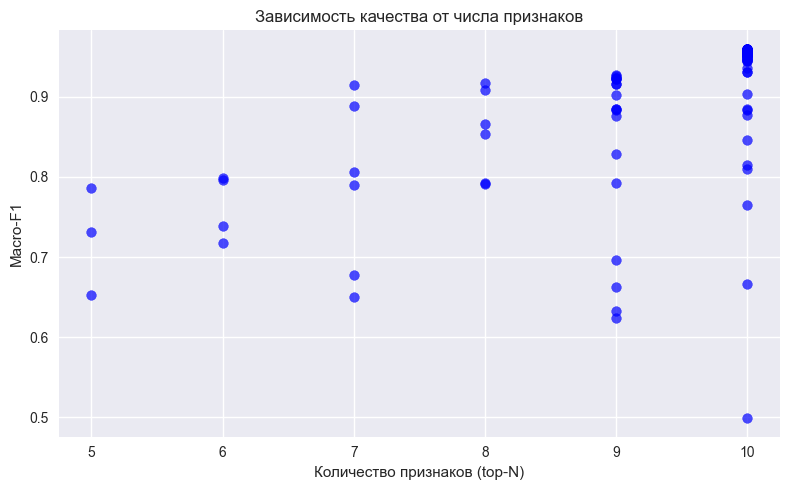

In [55]:
trials_df = study.trials_dataframe()

n_features = trials_df['params_n_features']
scores = trials_df['value']

plt.figure(figsize=(8, 5))

plt.scatter(n_features, scores, c='blue', alpha=0.7)
plt.xlabel('Количество признаков (top-N)')
plt.ylabel('Macro-F1')
plt.title('Зависимость качества от числа признаков')
plt.grid(True)
plt.tight_layout()

plt.show()


**Визуализация изменения F1 в зависимости от Learning Rate:**

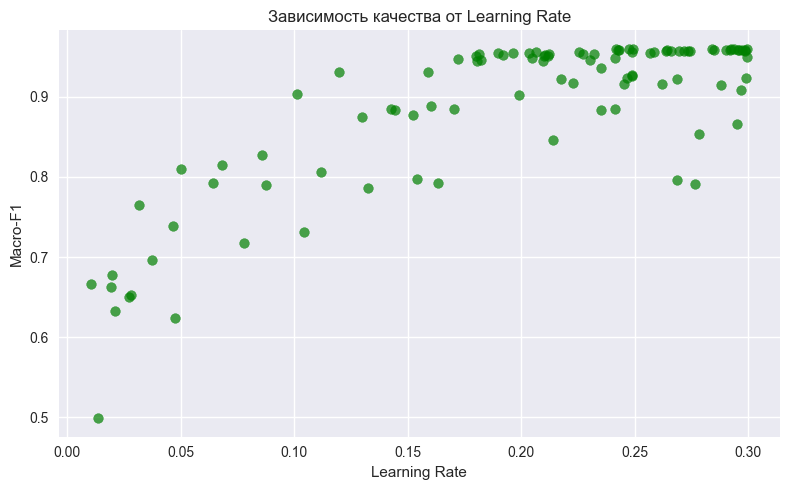

In [57]:
trials_df = study.trials_dataframe()

learning_rates = trials_df['params_learning_rate']
scores = trials_df['value']

plt.figure(figsize=(8, 5))

plt.scatter(learning_rates, scores, c='green', alpha=0.7)
plt.xlabel('Learning Rate')
plt.ylabel('Macro-F1')
plt.title('Зависимость качества от Learning Rate')
plt.grid(True)
plt.tight_layout()

plt.show()

**Обучение модели с лучшими параметрами:**

In [16]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

best_params = {'n_estimators': 90,
               'max_depth': 6,
               'learning_rate': 0.24189968310851612,
               'subsample': 0.7407549002451482,
               'colsample_bytree': 0.7655697796860741,
               'gamma': 0.02496423356778503,
               'min_child_weight': 5}

top_features = ['Destination Port', 
                'Init_Win_bytes_forward', 
                'Init_Win_bytes_backward',
                'Bwd Packets/s', 
                'min_seg_size_forward', 
                'Fwd IAT Std',
                'Flow IAT Min', 
                'Bwd Packet Length Min', 
                'Fwd Packets/s', 
                'Fwd IAT Min']

X_train_selected = X_train[top_features].copy()
X_test_selected = X_test[top_features].copy()

best_model = XGBClassifier(**best_params,
                           objective='multi:softprob',
                           num_class=len(np.unique(y_train)),
                           eval_metric='mlogloss',
                           random_state=42,
                           n_jobs=-1)

best_model.fit(X_train_selected, y_train, sample_weight=weights)

y_pred_optuna = best_model.predict(X_test_selected)
report_optuna = classification_report(y_test, y_pred_optuna, output_dict=True)

print(f"Macro-F1 (best_model): {report_optuna['macro avg']['f1-score']:.3f}")
print("Классификационный отчёт по классам:")
for label in report_optuna:
    if label not in ['accuracy', 'macro avg', 'weighted avg']:
        f1 = report_optuna[label]['f1-score']
        print(f"{label}: F1 = {f1:.3f}")

Macro-F1 (best_model): 0.960
Классификационный отчёт по классам:
0: F1 = 0.803
1: F1 = 0.997
2: F1 = 0.998
3: F1 = 0.999
4: F1 = 0.994
5: F1 = 0.966


**F1 для каждого класса (best_model):**

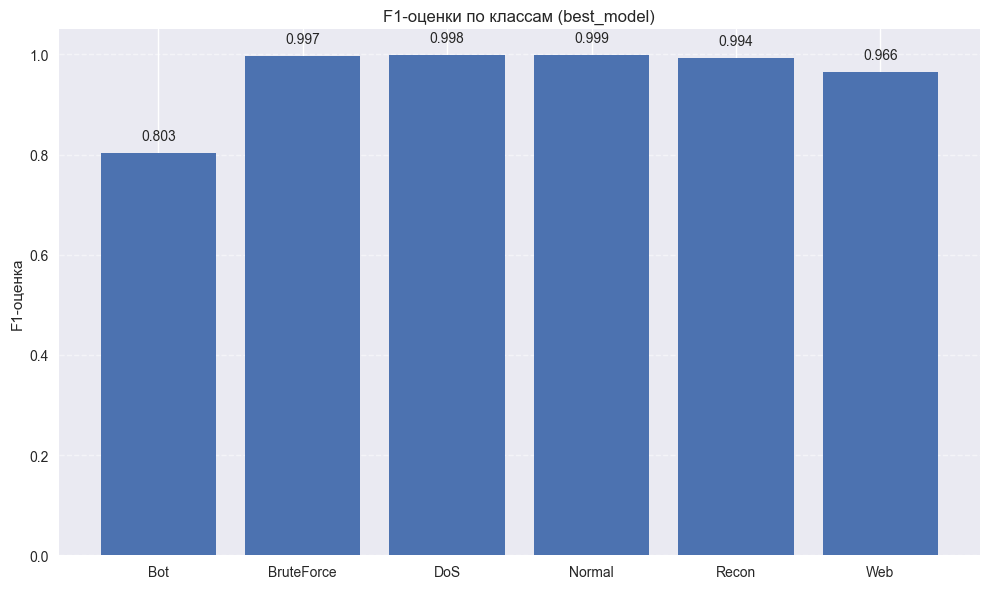

In [61]:
class_mapping = dict(zip(final_encoder.transform(final_encoder.classes_), final_encoder.classes_))
f1_scores = []
class_labels = []

for label_idx in report_optuna:
    if label_idx not in ['accuracy', 'macro avg', 'weighted avg']:
        class_name = class_mapping[int(label_idx)]
        f1 = report_optuna[label_idx]['f1-score']
        f1_scores.append(f1)
        class_labels.append(class_name)

plt.figure(figsize=(10, 6))

bars = plt.bar(class_labels, f1_scores)
plt.ylim(0, 1.05)
plt.ylabel('F1-оценка')
plt.title('F1-оценки по классам (best_model)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.3f}', ha='center', va='bottom')
plt.tight_layout()

plt.show()

**Confusion Matrix (best_model):**

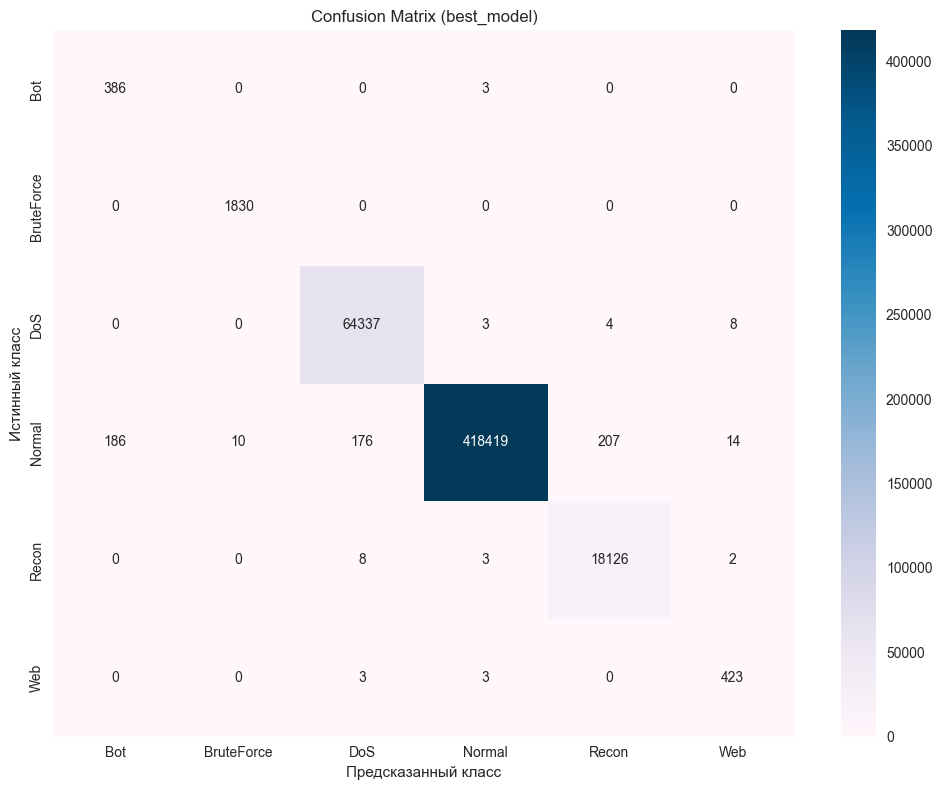

In [62]:
cm = confusion_matrix(y_test, y_pred_optuna)
labels = [class_mapping[i] for i in range(len(class_mapping))]

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=labels, yticklabels=labels)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Confusion Matrix (best_model)')
plt.tight_layout()

plt.show()

**Сравнение F1 базовой и лучшей модели по классам:**

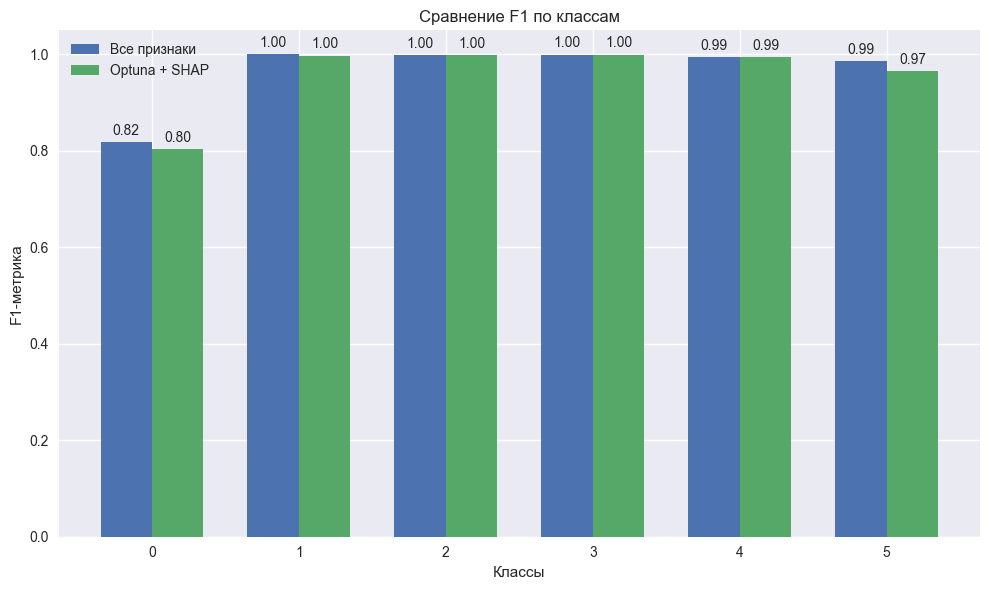

In [63]:
classes = [str(c) for c in np.unique(y_train)]
f1_all = [report_all[c]['f1-score'] for c in classes]
f1_optuna = [report_optuna[c]['f1-score'] for c in classes]

x = np.arange(len(classes))
width = 0.35

plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, f1_all, width, label='Все признаки')
rects2 = ax.bar(x + width/2, f1_optuna, width, label='Optuna + SHAP')
ax.set_ylabel('F1-метрика')
ax.set_xlabel('Классы')
ax.set_title('Сравнение F1 по классам')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom')
plt.tight_layout()

plt.show()

**Сохранение лучшей модели:**

In [64]:
top_features

array(['Destination Port', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'Bwd Packets/s', 'min_seg_size_forward',
       'Fwd IAT Std', 'Flow IAT Min', 'Bwd Packet Length Min',
       'Fwd Packets/s', 'Fwd IAT Min'], dtype=object)

In [17]:
pipeline_bundle = {'model': best_model,
                   'selected_features': top_features,
                   'label_encoder': final_encoder,
                   'sample_weight': weights}

joblib.dump(pipeline_bundle, 'xgb_pipeline_bundle.pkl')

['xgb_pipeline_bundle.pkl']